In [24]:
import torch
import torch.nn.functional as F
from torch import nn

import whisper
from whisper.audio import (
    log_mel_spectrogram,
    pad_or_trim,
    load_audio,
)

import jiwer
from suta import *
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
model = whisper.load_model("base.en")

In [3]:
# collect trainable params
params = []
names = []

for name, param in model.named_parameters():
    param.requires_grad = False

for nm, m in model.named_modules():
    # print(str(nm).split('.'))
    trainable = ['weight', 'bias']
    # train_LN
    if isinstance(m, nn.LayerNorm) and str(nm).split('.')[0] == 'encoder':
        for np, p in m.named_parameters():
            if np in trainable:  
                p.requires_grad = True
                params.append(p)
                names.append(f"{nm}.{np}")
    # train_feature
    if len(str(nm).split('.')) > 1:
        if str(nm).split('.')[0] == 'encoder' and (str(nm).split('.')[1] == 'conv1' or str(nm).split('.')[1] == 'conv2'):
            for np, p in m.named_parameters():
                p.requires_grad = True
                params.append(p)
                names.append(f"{nm}.{np}")
print(names)
# check trainable parameter
# for name, param in model.named_parameters():
#     print("name: ", name)
#     print("requires_grad: ", param.requires_grad)

['encoder.conv1.weight', 'encoder.conv1.bias', 'encoder.conv2.weight', 'encoder.conv2.bias', 'encoder.blocks.0.attn_ln.weight', 'encoder.blocks.0.attn_ln.bias', 'encoder.blocks.0.mlp_ln.weight', 'encoder.blocks.0.mlp_ln.bias', 'encoder.blocks.1.attn_ln.weight', 'encoder.blocks.1.attn_ln.bias', 'encoder.blocks.1.mlp_ln.weight', 'encoder.blocks.1.mlp_ln.bias', 'encoder.blocks.2.attn_ln.weight', 'encoder.blocks.2.attn_ln.bias', 'encoder.blocks.2.mlp_ln.weight', 'encoder.blocks.2.mlp_ln.bias', 'encoder.blocks.3.attn_ln.weight', 'encoder.blocks.3.attn_ln.bias', 'encoder.blocks.3.mlp_ln.weight', 'encoder.blocks.3.mlp_ln.bias', 'encoder.blocks.4.attn_ln.weight', 'encoder.blocks.4.attn_ln.bias', 'encoder.blocks.4.mlp_ln.weight', 'encoder.blocks.4.mlp_ln.bias', 'encoder.blocks.5.attn_ln.weight', 'encoder.blocks.5.attn_ln.bias', 'encoder.blocks.5.mlp_ln.weight', 'encoder.blocks.5.mlp_ln.bias', 'encoder.ln_post.weight', 'encoder.ln_post.bias']


In [4]:
# load audio
options = whisper.DecodingOptions(language="en", without_timestamps=True)
audio = load_audio(file='./p232_022.wav')
audio = pad_or_trim(audio)
mel = log_mel_spectrogram(audio)
mel = mel.unsqueeze(-1)
mel = mel.permute(2,0,1)

## Calculate loss and adapt

In [5]:
optimizer, scheduler = setup_optimizer(params, 'AdamW', lr=3e-4, scheduler=None)
mel = mel.to(DEVICE)
model = model.to(DEVICE)
outputs = model.decode(mel, options)


[INFO]    optimizer: <class 'torch.optim.adamw.AdamW'>
[INFO]    scheduler: None


In [35]:
outputs

([DecodingResult(audio_features=tensor([[-6.8994e-01,  5.6152e-01, -9.4238e-01,  ...,  2.4438e-01,
           -4.6631e-01,  2.3331e-02],
          [-5.1758e-01,  4.1162e-01, -6.4731e-05,  ...,  9.3115e-01,
           -8.7305e-01,  1.8359e-01],
          [-9.4092e-01, -2.0190e-01,  3.5303e-01,  ...,  5.2930e-01,
           -1.8066e-01, -3.0908e-01],
          ...,
          [ 3.3105e-01, -6.3818e-01, -9.0723e-01,  ...,  1.0029e+00,
           -2.2168e-01,  8.9893e-01],
          [ 7.2314e-01, -3.7769e-01, -4.2725e-01,  ...,  1.1074e+00,
           -3.8501e-01,  5.4004e-01],
          [ 7.6709e-01, -7.2461e-01,  3.1763e-01,  ...,  6.4258e-01,
           -4.7339e-01,  2.2205e-01]], device='cuda:0', dtype=torch.float16,
         grad_fn=<UnbindBackward0>), language='en', language_probs=None, tokens=[383, 4036, 4165, 27223, 6515, 318, 531, 284, 307, 262, 1245, 286, 2208, 320, 9150, 286, 257, 1271, 286, 37469, 13], text='The actual primary rainbow observed is said to be the effect of superim

In [6]:
result_tensor = torch.stack(outputs[1], dim=0)
result_tensor=result_tensor.permute(1,0,2) # torch.Size([1, 5, 51864])
result_tensor.shape

torch.Size([1, 22, 51864])

In [29]:
val, idx = torch.topk(result_tensor,k=50)
val.shape

torch.Size([1, 22, 50])

In [31]:
e_loss_top50 = softmax_entropy(val/2.5).mean(0).mean()
e_loss_top50

tensor(2.4510, device='cuda:0', grad_fn=<MeanBackward0>)

/tmp/ipykernel_7677/2263383400.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(result_tensor[0][4]).detach().cpu(),marker='o', linestyle='',markersize=4)


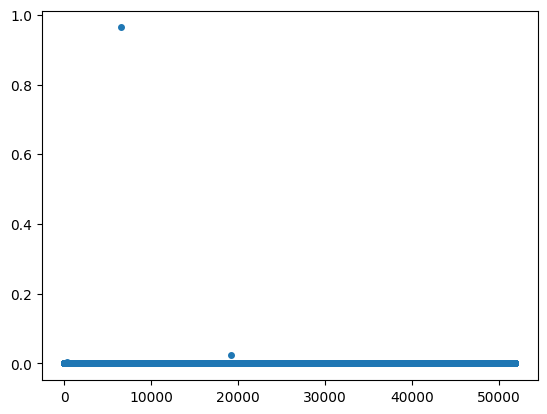

In [55]:
# plt.plot(result_tensor[0][2].detach().cpu(),marker='o', linestyle='',markersize=1)
plt.plot(F.softmax(result_tensor[0][4]).detach().cpu(),marker='o', linestyle='',markersize=4)

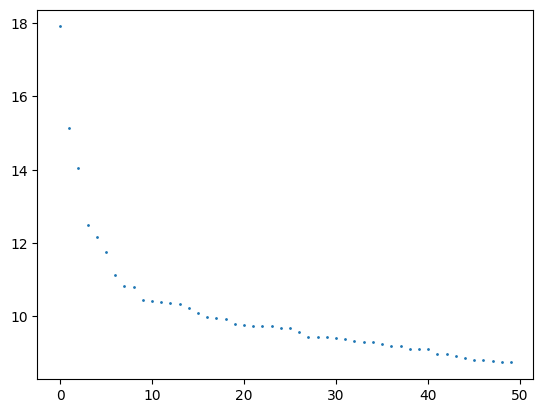

In [47]:
tmp = val[0][0]
plt.plot(tmp.detach().cpu(),marker='o', linestyle='',markersize=1)

In [35]:
tmp = result_tensor[0][9].detach().cpu()

In [48]:
F.softmax(tmp,dim=-1)

tensor([3.0077e-07, 8.5195e-06, 4.1671e-08,  ..., 5.6514e-08, 3.4546e-08,
        2.5673e-08])

In [36]:
torch.where(tmp>5)

(tensor([    0,     1,     2,  ..., 51861, 51862, 51863]),)

In [44]:
_, idx = torch.topk(tmp,k=50)

In [47]:
tmp[idx]

tensor([27.4219, 23.8438, 21.6719, 20.8594, 20.4844, 20.3906, 20.2188, 20.2031,
        20.2031, 19.8750, 19.7500, 19.2188, 19.1406, 18.8750, 18.2812, 18.1406,
        17.9375, 17.9219, 17.8594, 17.7969, 17.7656, 17.7500, 17.6094, 17.5312,
        17.4219, 17.4062, 17.3438, 17.2969, 17.2500, 17.1562, 17.0625, 17.0469,
        17.0156, 16.9688, 16.8594, 16.7188, 16.5000, 16.4844, 16.4688, 16.4688,
        16.4219, 16.3594, 16.2812, 16.2500, 16.2500, 16.2344, 16.2188, 16.2031,
        16.1719, 16.1406])

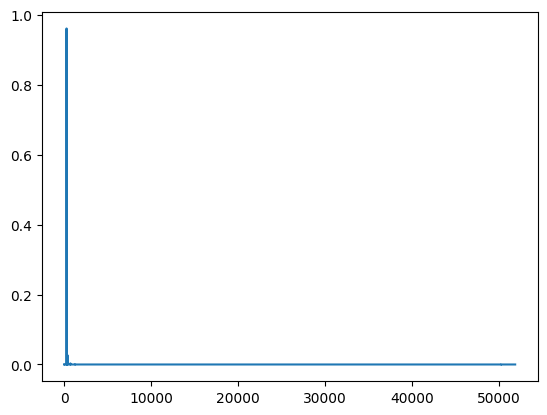

In [42]:
plt.plot(F.softmax(tmp,dim=0))

In [34]:
e_loss = softmax_entropy(result_tensor/2.5).mean(0).mean()
e_loss


tensor(10.2570, device='cuda:0', grad_fn=<MeanBackward0>)